## Finding similar energy consumption shapeletes in the past

### Using TFT

In [ ]:
%cd '/content/drive/MyDrive/Interpretable Forecasting of Buildings Energy Consumption/code'

/content/drive/MyDrive/Interpretable Forecasting of Buildings Energy Consumption/code


#### Model

In [ ]:
# coding=utf-8
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Temporal Fusion Transformer Model.

Contains the full TFT architecture and associated components. Defines functions
for training, evaluation and prediction using simple Pandas Dataframe inputs.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gc
import json
import os
import shutil

import data_formatters.base
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow as tf

# Layer definitions.
concat = tf.keras.backend.concatenate
stack = tf.keras.backend.stack
K = tf.keras.backend
Add = tf.keras.layers.Add
LayerNorm = tf.keras.layers.LayerNormalization
Dense = tf.keras.layers.Dense
Multiply = tf.keras.layers.Multiply
Dropout = tf.keras.layers.Dropout
Activation = tf.keras.layers.Activation
Lambda = tf.keras.layers.Lambda

# Default input types.
InputTypes = data_formatters.base.InputTypes


# Layer utility functions.
def linear_layer(size,
                 activation=None,
                 use_time_distributed=False,
                 use_bias=True):
  """Returns simple Keras linear layer.

  Args:
    size: Output size
    activation: Activation function to apply if required
    use_time_distributed: Whether to apply layer across time
    use_bias: Whether bias should be included in layer
  """
  linear = tf.keras.layers.Dense(size, activation=activation, use_bias=use_bias)
  if use_time_distributed:
    linear = tf.keras.layers.TimeDistributed(linear)
  return linear


def apply_mlp(inputs,
              hidden_size,
              output_size,
              output_activation=None,
              hidden_activation='tanh',
              use_time_distributed=False):
  """Applies simple feed-forward network to an input.

  Args:
    inputs: MLP inputs
    hidden_size: Hidden state size
    output_size: Output size of MLP
    output_activation: Activation function to apply on output
    hidden_activation: Activation function to apply on input
    use_time_distributed: Whether to apply across time

  Returns:
    Tensor for MLP outputs.
  """
  if use_time_distributed:
    hidden = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_size, activation=hidden_activation))(
            inputs)
    return tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(output_size, activation=output_activation))(
            hidden)
  else:
    hidden = tf.keras.layers.Dense(
        hidden_size, activation=hidden_activation)(
            inputs)
    return tf.keras.layers.Dense(
        output_size, activation=output_activation)(
            hidden)


def apply_gating_layer(x,
                       hidden_layer_size,
                       dropout_rate=None,
                       use_time_distributed=True,
                       activation=None):
  """Applies a Gated Linear Unit (GLU) to an input.

  Args:
    x: Input to gating layer
    hidden_layer_size: Dimension of GLU
    dropout_rate: Dropout rate to apply if any
    use_time_distributed: Whether to apply across time
    activation: Activation function to apply to the linear feature transform if
      necessary

  Returns:
    Tuple of tensors for: (GLU output, gate)
  """

  if dropout_rate is not None:
    x = tf.keras.layers.Dropout(dropout_rate)(x)

  if use_time_distributed:
    activation_layer = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_layer_size, activation=activation))(
            x)
    gated_layer = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid'))(
            x)
  else:
    activation_layer = tf.keras.layers.Dense(
        hidden_layer_size, activation=activation)(
            x)
    gated_layer = tf.keras.layers.Dense(
        hidden_layer_size, activation='sigmoid')(
            x)

  return tf.keras.layers.Multiply()([activation_layer,
                                     gated_layer]), gated_layer


def add_and_norm(x_list):
  """Applies skip connection followed by layer normalisation.

  Args:
    x_list: List of inputs to sum for skip connection

  Returns:
    Tensor output from layer.
  """
  tmp = Add()(x_list)
  tmp = LayerNorm()(tmp)
  return tmp


def gated_residual_network(x,
                           hidden_layer_size,
                           output_size=None,
                           dropout_rate=None,
                           use_time_distributed=True,
                           additional_context=None,
                           return_gate=False):
  """Applies the gated residual network (GRN) as defined in paper.

  Args:
    x: Network inputs
    hidden_layer_size: Internal state size
    output_size: Size of output layer
    dropout_rate: Dropout rate if dropout is applied
    use_time_distributed: Whether to apply network across time dimension
    additional_context: Additional context vector to use if relevant
    return_gate: Whether to return GLU gate for diagnostic purposes

  Returns:
    Tuple of tensors for: (GRN output, GLU gate)
  """

  # Setup skip connection
  if output_size is None:
    output_size = hidden_layer_size
    skip = x
  else:
    linear = Dense(output_size)
    if use_time_distributed:
      linear = tf.keras.layers.TimeDistributed(linear)
    skip = linear(x)

  # Apply feedforward network
  hidden = linear_layer(
      hidden_layer_size,
      activation=None,
      use_time_distributed=use_time_distributed)(
          x)
  if additional_context is not None:
    hidden = hidden + linear_layer(
        hidden_layer_size,
        activation=None,
        use_time_distributed=use_time_distributed,
        use_bias=False)(
            additional_context)
  hidden = tf.keras.layers.Activation('elu')(hidden)
  hidden = linear_layer(
      hidden_layer_size,
      activation=None,
      use_time_distributed=use_time_distributed)(
          hidden)

  gating_layer, gate = apply_gating_layer(
      hidden,
      output_size,
      dropout_rate=dropout_rate,
      use_time_distributed=use_time_distributed,
      activation=None)

  if return_gate:
    return add_and_norm([skip, gating_layer]), gate
  else:
    return add_and_norm([skip, gating_layer])


# Attention Components.
def get_decoder_mask(self_attn_inputs):
  """Returns causal mask to apply for self-attention layer.

  Args:
    self_attn_inputs: Inputs to self attention layer to determine mask shape
  """
  len_s = tf.shape(input=self_attn_inputs)[1]
  bs = tf.shape(input=self_attn_inputs)[:1]
  mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
  return mask


class ScaledDotProductAttention():
  """Defines scaled dot product attention layer.

  Attributes:
    dropout: Dropout rate to use
    activation: Normalisation function for scaled dot product attention (e.g.
      softmax by default)
  """

  def __init__(self, attn_dropout=0.0):
    self.dropout = Dropout(attn_dropout)
    self.activation = Activation('softmax')

  def __call__(self, q, k, v, mask):
    """Applies scaled dot product attention.

    Args:
      q: Queries
      k: Keys
      v: Values
      mask: Masking if required -- sets softmax to very large value

    Returns:
      Tuple of (layer outputs, attention weights)
    """
    temper = tf.sqrt(tf.cast(tf.shape(input=k)[-1], dtype='float32'))
    attn = Lambda(lambda x: K.batch_dot(x[0], x[1], axes=[2, 2]) / temper)(
        [q, k])  # shape=(batch, q, k)
    if mask is not None:
      mmask = Lambda(lambda x: (-1e+9) * (1. - K.cast(x, 'float32')))(
          mask)  # setting to infinity
      attn = Add()([attn, mmask])
    attn = self.activation(attn)
    attn = self.dropout(attn)
    output = Lambda(lambda x: K.batch_dot(x[0], x[1]))([attn, v])
    return output, attn


class InterpretableMultiHeadAttention():
  """Defines interpretable multi-head attention layer.

  Attributes:
    n_head: Number of heads
    d_k: Key/query dimensionality per head
    d_v: Value dimensionality
    dropout: Dropout rate to apply
    qs_layers: List of queries across heads
    ks_layers: List of keys across heads
    vs_layers: List of values across heads
    attention: Scaled dot product attention layer
    w_o: Output weight matrix to project internal state to the original TFT
      state size
  """

  def __init__(self, n_head, d_model, dropout):
    """Initialises layer.

    Args:
      n_head: Number of heads
      d_model: TFT state dimensionality
      dropout: Dropout discard rate
    """

    self.n_head = n_head
    self.d_k = self.d_v = d_k = d_v = d_model // n_head
    self.dropout = dropout

    self.qs_layers = []
    self.ks_layers = []
    self.vs_layers = []

    # Use same value layer to facilitate interp
    vs_layer = Dense(d_v, use_bias=False)

    for _ in range(n_head):
      self.qs_layers.append(Dense(d_k, use_bias=False))
      self.ks_layers.append(Dense(d_k, use_bias=False))
      self.vs_layers.append(vs_layer)  # use same vs_layer

    self.attention = ScaledDotProductAttention()
    self.w_o = Dense(d_model, use_bias=False)

  def __call__(self, q, k, v, mask=None):
    """Applies interpretable multihead attention.

    Using T to denote the number of time steps fed into the transformer.

    Args:
      q: Query tensor of shape=(?, T, d_model)
      k: Key of shape=(?, T, d_model)
      v: Values of shape=(?, T, d_model)
      mask: Masking if required with shape=(?, T, T)

    Returns:
      Tuple of (layer outputs, attention weights)
    """
    n_head = self.n_head

    heads = []
    attns = []
    for i in range(n_head):
      qs = self.qs_layers[i](q)
      ks = self.ks_layers[i](k)
      vs = self.vs_layers[i](v)
      head, attn = self.attention(qs, ks, vs, mask)

      head_dropout = Dropout(self.dropout)(head)
      heads.append(head_dropout)
      attns.append(attn)
    head = K.stack(heads) if n_head > 1 else heads[0]
    attn = K.stack(attns)

    outputs = K.mean(head, axis=0) if n_head > 1 else head
    outputs = self.w_o(outputs)
    outputs = Dropout(self.dropout)(outputs)  # output dropout

    return outputs, attn


class TFTDataCache(object):
  """Caches data for the TFT."""

  _data_cache = {}

  @classmethod
  def update(cls, data, key):
    """Updates cached data.

    Args:
      data: Source to update
      key: Key to dictionary location
    """
    cls._data_cache[key] = data

  @classmethod
  def get(cls, key):
    """Returns data stored at key location."""
    return cls._data_cache[key].copy()

  @classmethod
  def contains(cls, key):
    """Retuns boolean indicating whether key is present in cache."""

    return key in cls._data_cache


# TFT model definitions.
class TemporalFusionTransformer(object):
  """Defines Temporal Fusion Transformer.

  Attributes:
    name: Name of model
    time_steps: Total number of input time steps per forecast date (i.e. Width
      of Temporal fusion decoder N)
    input_size: Total number of inputs
    output_size: Total number of outputs
    category_counts: Number of categories per categorical variable
    n_multiprocessing_workers: Number of workers to use for parallel
      computations
    column_definition: List of tuples of (string, DataType, InputType) that
      define each column
    quantiles: Quantiles to forecast for TFT
    use_cudnn: Whether to use Keras CuDNNLSTM or standard LSTM layers
    hidden_layer_size: Internal state size of TFT
    dropout_rate: Dropout discard rate
    max_gradient_norm: Maximum norm for gradient clipping
    learning_rate: Initial learning rate of ADAM optimizer
    minibatch_size: Size of minibatches for training
    num_epochs: Maximum number of epochs for training
    early_stopping_patience: Maximum number of iterations of non-improvement
      before early stopping kicks in
    num_encoder_steps: Size of LSTM encoder -- i.e. number of past time steps
      before forecast date to use
    num_stacks: Number of self-attention layers to apply (default is 1 for basic
      TFT)
    num_heads: Number of heads for interpretable mulit-head attention
    model: Keras model for TFT
  """

  def __init__(self, raw_params, use_cudnn=False):
    """Builds TFT from parameters.

    Args:
      raw_params: Parameters to define TFT
      use_cudnn: Whether to use CUDNN GPU optimised LSTM
    """

    self.name = self.__class__.__name__

    params = dict(raw_params)  # copy locally

    # Data parameters
    self.time_steps = int(params['total_time_steps'])
    self.input_size = int(params['input_size'])
    self.output_size = int(params['output_size'])
    self.category_counts = json.loads(str(params['category_counts']))
    self.n_multiprocessing_workers = int(params['multiprocessing_workers'])

    # Relevant indices for TFT
    self._input_obs_loc = json.loads(str(params['input_obs_loc']))
    self._static_input_loc = json.loads(str(params['static_input_loc']))
    self._known_regular_input_idx = json.loads(
        str(params['known_regular_inputs']))
    self._known_categorical_input_idx = json.loads(
        str(params['known_categorical_inputs']))

    self.column_definition = params['column_definition']

    # Network params
    self.quantiles = [0.1, 0.5, 0.9]
    self.use_cudnn = use_cudnn  # Whether to use GPU optimised LSTM
    self.hidden_layer_size = int(params['hidden_layer_size'])
    self.dropout_rate = float(params['dropout_rate'])
    self.max_gradient_norm = float(params['max_gradient_norm'])
    self.learning_rate = float(params['learning_rate'])
    self.minibatch_size = int(params['minibatch_size'])
    self.num_epochs = int(params['num_epochs'])
    self.early_stopping_patience = int(params['early_stopping_patience'])

    self.num_encoder_steps = int(params['num_encoder_steps'])
    self.num_stacks = int(params['stack_size'])
    self.num_heads = int(params['num_heads'])

    # Serialisation options
    self._temp_folder = os.path.join(params['model_folder'], 'tmp')
    self.reset_temp_folder()

    # Extra components to store Tensorflow nodes for attention computations
    self._input_placeholder = None
    self._attention_components = None
    self._prediction_parts = None

    print('*** {} params ***'.format(self.name))
    for k in params:
      print('# {} = {}'.format(k, params[k]))

    # Build model
    self.model = self.build_model()

  def get_tft_embeddings(self, all_inputs):
    """Transforms raw inputs to embeddings.

    Applies linear transformation onto continuous variables and uses embeddings
    for categorical variables.

    Args:
      all_inputs: Inputs to transform

    Returns:
      Tensors for transformed inputs.
    """

    time_steps = self.time_steps

    # Sanity checks
    for i in self._known_regular_input_idx:
      if i in self._input_obs_loc:
        raise ValueError('Observation cannot be known a priori!')
    for i in self._input_obs_loc:
      if i in self._static_input_loc:
        raise ValueError('Observation cannot be static!')

    if all_inputs.get_shape().as_list()[-1] != self.input_size:
      raise ValueError(
          'Illegal number of inputs! Inputs observed={}, expected={}'.format(
              all_inputs.get_shape().as_list()[-1], self.input_size))

    num_categorical_variables = len(self.category_counts)
    num_regular_variables = self.input_size - num_categorical_variables

    embedding_sizes = [
        self.hidden_layer_size for i, size in enumerate(self.category_counts)
    ]

    embeddings = []
    for i in range(num_categorical_variables):

      embedding = tf.keras.Sequential([
          tf.keras.layers.InputLayer([time_steps]),
          tf.keras.layers.Embedding(
              self.category_counts[i],
              embedding_sizes[i],
              input_length=time_steps,
              dtype=tf.float32)
      ])
      embeddings.append(embedding)

    regular_inputs, categorical_inputs \
        = all_inputs[:, :, :num_regular_variables], \
          all_inputs[:, :, num_regular_variables:]

    embedded_inputs = [
        embeddings[i](categorical_inputs[Ellipsis, i])
        for i in range(num_categorical_variables)
    ]

    # Static inputs
    if self._static_input_loc:
      static_inputs = [tf.keras.layers.Dense(self.hidden_layer_size)(
          regular_inputs[:, 0, i:i + 1]) for i in range(num_regular_variables)
                       if i in self._static_input_loc] \
          + [embedded_inputs[i][:, 0, :]
             for i in range(num_categorical_variables)
             if i + num_regular_variables in self._static_input_loc]
      static_inputs = tf.keras.backend.stack(static_inputs, axis=1)

    else:
      static_inputs = None

    def convert_real_to_embedding(x):
      """Applies linear transformation for time-varying inputs."""
      return tf.keras.layers.TimeDistributed(
          tf.keras.layers.Dense(self.hidden_layer_size))(
              x)

    # Targets
    obs_inputs = tf.keras.backend.stack([
        convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
        for i in self._input_obs_loc
    ],
                                        axis=-1)

    # Observed (a prioir unknown) inputs
    wired_embeddings = []
    for i in range(num_categorical_variables):
      if i not in self._known_categorical_input_idx \
        and  i + num_regular_variables  not in self._input_obs_loc:
        e = embeddings[i](categorical_inputs[:, :, i])
        wired_embeddings.append(e)

    unknown_inputs = []
    for i in range(regular_inputs.shape[-1]):
      if i not in self._known_regular_input_idx \
          and i not in self._input_obs_loc:
        e = convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
        unknown_inputs.append(e)

    if unknown_inputs + wired_embeddings:
      unknown_inputs = tf.keras.backend.stack(
          unknown_inputs + wired_embeddings, axis=-1)
    else:
      unknown_inputs = None

    # A priori known inputs
    known_regular_inputs = [
        convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
        for i in self._known_regular_input_idx
        if i not in self._static_input_loc
    ]
    known_categorical_inputs = [
        embedded_inputs[i]
        for i in self._known_categorical_input_idx
        if i + num_regular_variables not in self._static_input_loc
    ]

    known_combined_layer = tf.keras.backend.stack(
        known_regular_inputs + known_categorical_inputs, axis=-1)

    return unknown_inputs, known_combined_layer, obs_inputs, static_inputs

  def _get_single_col_by_type(self, input_type):
    """Returns name of single column for input type."""

    return utils.get_single_col_by_input_type(input_type,
                                              self.column_definition)

  def training_data_cached(self):
    """Returns boolean indicating if training data has been cached."""

    return TFTDataCache.contains('train') and TFTDataCache.contains('valid')

  def cache_batched_data(self, data, cache_key, num_samples=-1):
    """Batches and caches data once for using during training.

    Args:
      data: Data to batch and cache
      cache_key: Key used for cache
      num_samples: Maximum number of samples to extract (-1 to use all data)
    """

    if num_samples > 0:
      TFTDataCache.update(
          self._batch_sampled_data(data, max_samples=num_samples), cache_key)
    else:
      TFTDataCache.update(self._batch_data(data), cache_key)

    print('Cached data "{}" updated'.format(cache_key))

  def _batch_sampled_data(self, data, max_samples):
    """Samples segments into a compatible format.

    Args:
      data: Sources data to sample and batch
      max_samples: Maximum number of samples in batch

    Returns:
      Dictionary of batched data with the maximum samples specified.
    """

    if max_samples < 1:
      raise ValueError(
          'Illegal number of samples specified! samples={}'.format(max_samples))

    id_col = self._get_single_col_by_type(InputTypes.ID)
    time_col = self._get_single_col_by_type(InputTypes.TIME)

    data.sort_values(by=[id_col, time_col], inplace=True)

    print('Getting valid sampling locations.')
    valid_sampling_locations = []
    split_data_map = {}
    for identifier, df in data.groupby(id_col):
      print('Getting locations for {}'.format(identifier))
      num_entries = len(df)
      if num_entries >= self.time_steps:
        valid_sampling_locations += [
            (identifier, self.time_steps + i)
            for i in range(num_entries - self.time_steps + 1)
        ]
      split_data_map[identifier] = df

    inputs = np.zeros((max_samples, self.time_steps, self.input_size))
    outputs = np.zeros((max_samples, self.time_steps, self.output_size))
    time = np.empty((max_samples, self.time_steps, 1), dtype=object)
    identifiers = np.empty((max_samples, self.time_steps, 1), dtype=object)

    if max_samples > 0 and len(valid_sampling_locations) > max_samples:
      print('Extracting {} samples...'.format(max_samples))
      ranges = [
          valid_sampling_locations[i] for i in np.random.choice(
              len(valid_sampling_locations), max_samples, replace=False)
      ]
    else:
      print('Max samples={} exceeds # available segments={}'.format(
          max_samples, len(valid_sampling_locations)))
      ranges = valid_sampling_locations

    id_col = self._get_single_col_by_type(InputTypes.ID)
    time_col = self._get_single_col_by_type(InputTypes.TIME)
    target_col = self._get_single_col_by_type(InputTypes.TARGET)
    input_cols = [
        tup[0]
        for tup in self.column_definition
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

    for i, tup in enumerate(ranges):
      if (i + 1 % 1000) == 0:
        print(i + 1, 'of', max_samples, 'samples done...')
      identifier, start_idx = tup
      sliced = split_data_map[identifier].iloc[start_idx -
                                               self.time_steps:start_idx]
      inputs[i, :, :] = sliced[input_cols]
      outputs[i, :, :] = sliced[[target_col]]
      time[i, :, 0] = sliced[time_col]
      identifiers[i, :, 0] = sliced[id_col]

    sampled_data = {
        'inputs': inputs,
        'outputs': outputs[:, self.num_encoder_steps:, :],
        'active_entries': np.ones_like(outputs[:, self.num_encoder_steps:, :]),
        'time': time,
        'identifier': identifiers
    }

    return sampled_data

  def _batch_data(self, data):
    """Batches data for training.

    Converts raw dataframe from a 2-D tabular format to a batched 3-D array
    to feed into Keras model.

    Args:
      data: DataFrame to batch

    Returns:
      Batched Numpy array with shape=(?, self.time_steps, self.input_size)
    """

    # Functions.
    def _batch_single_entity(input_data):
      time_steps = len(input_data)
      lags = self.time_steps
      x = input_data.values
      print('********************************************time_steps', time_steps)
      print('********************************************lags', lags)
      if time_steps >= lags:
        return np.stack(
            [x[i:time_steps - (lags - 1) + i, :] for i in range(lags)], axis=1)

      else:
        return None

    id_col = self._get_single_col_by_type(InputTypes.ID)
    time_col = self._get_single_col_by_type(InputTypes.TIME)
    target_col = self._get_single_col_by_type(InputTypes.TARGET)
    input_cols = [
        tup[0]
        for tup in self.column_definition
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

    data_map = {}
    # for _, sliced in data.groupby(id_col):
    print('********************************************len data', len(data))
    for idx in range(len(data)):

      # print('********************************************idx', idx)
      if idx % (self.time_steps - self.num_encoder_steps) == 0:
        if idx+self.time_steps > len(data): break
        else:
          print('******************************************** idx in the if', idx)
          sliced = data[idx:idx+self.time_steps].copy()

      col_mappings = {
          'identifier': [id_col],
          'time': [time_col],
          'outputs': [target_col],
          'inputs': input_cols
      }

      for k in col_mappings:
        cols = col_mappings[k]
        arr = _batch_single_entity(sliced[cols].copy())

        if k not in data_map:
          # if k == 'outputs': print('outputs is not in data_map')
          data_map[k] = [arr]
        else:
          # if k == 'outputs': print('outputs is in data_map')
          data_map[k].append(arr)
          if arr is not None:
            print('**********************************************arr', arr.shape)
          else:
            print('**********************************************None')

    # Combine all data
    for k in data_map:
      data_map[k] = np.concatenate(data_map[k], axis=0)

    # Shorten target so we only get decoder steps
    data_map['outputs'] = data_map['outputs'][:, self.num_encoder_steps:, :]

    active_entries = np.ones_like(data_map['outputs'])
    if 'active_entries' not in data_map:
      data_map['active_entries'] = active_entries
    else:
      data_map['active_entries'].append(active_entries)

    return data_map

  def _get_active_locations(self, x):
    """Formats sample weights for Keras training."""
    return (np.sum(x, axis=-1) > 0.0) * 1.0

  def _build_base_graph(self):
    """Returns graph defining layers of the TFT."""

    # Size definitions.
    time_steps = self.time_steps
    combined_input_size = self.input_size
    encoder_steps = self.num_encoder_steps

    # Inputs.
    all_inputs = tf.keras.layers.Input(
        shape=(
            time_steps,
            combined_input_size,
        ))

    unknown_inputs, known_combined_layer, obs_inputs, static_inputs \
        = self.get_tft_embeddings(all_inputs)

    # Isolate known and observed historical inputs.
    if unknown_inputs is not None:
      historical_inputs = concat([
          unknown_inputs[:, :encoder_steps, :],
          known_combined_layer[:, :encoder_steps, :],
          obs_inputs[:, :encoder_steps, :]
      ],
                                 axis=-1)
    else:
      historical_inputs = concat([
          known_combined_layer[:, :encoder_steps, :],
          obs_inputs[:, :encoder_steps, :]
      ],
                                 axis=-1)

    # Isolate only known future inputs.
    future_inputs = known_combined_layer[:, encoder_steps:, :]

    def static_combine_and_mask(embedding):
      """Applies variable selection network to static inputs.

      Args:
        embedding: Transformed static inputs

      Returns:
        Tensor output for variable selection network
      """

      # Add temporal features
      _, num_static, _ = embedding.get_shape().as_list()

      flatten = tf.keras.layers.Flatten()(embedding)

      # Nonlinear transformation with gated residual network.
      mlp_outputs = gated_residual_network(
          flatten,
          self.hidden_layer_size,
          output_size=num_static,
          dropout_rate=self.dropout_rate,
          use_time_distributed=False,
          additional_context=None)

      sparse_weights = tf.keras.layers.Activation('softmax')(mlp_outputs)
      sparse_weights = K.expand_dims(sparse_weights, axis=-1)

      trans_emb_list = []
      for i in range(num_static):
        e = gated_residual_network(
            embedding[:, i:i + 1, :],
            self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False)
        trans_emb_list.append(e)

      transformed_embedding = concat(trans_emb_list, axis=1)

      combined = tf.keras.layers.Multiply()(
          [sparse_weights, transformed_embedding])

      static_vec = K.sum(combined, axis=1)

      return static_vec, sparse_weights

    static_encoder, static_weights = static_combine_and_mask(static_inputs)

    static_context_variable_selection = gated_residual_network(
        static_encoder,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        use_time_distributed=False)
    static_context_enrichment = gated_residual_network(
        static_encoder,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        use_time_distributed=False)
    static_context_state_h = gated_residual_network(
        static_encoder,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        use_time_distributed=False)
    static_context_state_c = gated_residual_network(
        static_encoder,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        use_time_distributed=False)

    def lstm_combine_and_mask(embedding):
      """Apply temporal variable selection networks.

      Args:
        embedding: Transformed inputs.

      Returns:
        Processed tensor outputs.
      """

      # Add temporal features
      _, time_steps, embedding_dim, num_inputs = embedding.get_shape().as_list()

      flatten = K.reshape(embedding,
                          [-1, time_steps, embedding_dim * num_inputs])

      expanded_static_context = K.expand_dims(
          static_context_variable_selection, axis=1)

      # Variable selection weights
      mlp_outputs, static_gate = gated_residual_network(
          flatten,
          self.hidden_layer_size,
          output_size=num_inputs,
          dropout_rate=self.dropout_rate,
          use_time_distributed=True,
          additional_context=expanded_static_context,
          return_gate=True)

      sparse_weights = tf.keras.layers.Activation('softmax')(mlp_outputs)
      sparse_weights = tf.expand_dims(sparse_weights, axis=2)

      # Non-linear Processing & weight application
      trans_emb_list = []
      for i in range(num_inputs):
        grn_output = gated_residual_network(
            embedding[Ellipsis, i],
            self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True)
        trans_emb_list.append(grn_output)

      transformed_embedding = stack(trans_emb_list, axis=-1)

      combined = tf.keras.layers.Multiply()(
          [sparse_weights, transformed_embedding])
      temporal_ctx = K.sum(combined, axis=-1)

      return temporal_ctx, sparse_weights, static_gate

    historical_features, historical_flags, _ = lstm_combine_and_mask(
        historical_inputs)
    future_features, future_flags, _ = lstm_combine_and_mask(future_inputs)

    # LSTM layer
    def get_lstm(return_state):
      """Returns LSTM cell initialized with default parameters."""
      if self.use_cudnn:
        lstm = tf.compat.v1.keras.layers.CuDNNLSTM(
            self.hidden_layer_size,
            return_sequences=True,
            return_state=return_state,
            stateful=False,
        )
      else:
        lstm = tf.keras.layers.LSTM(
            self.hidden_layer_size,
            return_sequences=True,
            return_state=return_state,
            stateful=False,
            # Additional params to ensure LSTM matches CuDNN, See TF 2.0 :
            # (https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
            activation='tanh',
            recurrent_activation='sigmoid',
            recurrent_dropout=0,
            unroll=False,
            use_bias=True)
      return lstm

    history_lstm, state_h, state_c \
        = get_lstm(return_state=True)(historical_features,
                                      initial_state=[static_context_state_h,
                                                     static_context_state_c])

    future_lstm = get_lstm(return_state=False)(
        future_features, initial_state=[state_h, state_c])

    lstm_layer = concat([history_lstm, future_lstm], axis=1)

    # Apply gated skip connection
    input_embeddings = concat([historical_features, future_features], axis=1)

    lstm_layer, _ = apply_gating_layer(
        lstm_layer, self.hidden_layer_size, self.dropout_rate, activation=None)
    temporal_feature_layer = add_and_norm([lstm_layer, input_embeddings])

    # Static enrichment layers
    expanded_static_context = K.expand_dims(static_context_enrichment, axis=1)
    enriched, _ = gated_residual_network(
        temporal_feature_layer,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        use_time_distributed=True,
        additional_context=expanded_static_context,
        return_gate=True)

    # Decoder self attention
    self_attn_layer = InterpretableMultiHeadAttention(
        self.num_heads, self.hidden_layer_size, dropout=self.dropout_rate)

    mask = get_decoder_mask(enriched)
    x, self_att \
        = self_attn_layer(enriched, enriched, enriched,
                          mask=mask)

    x, _ = apply_gating_layer(
        x,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        activation=None)
    x = add_and_norm([x, enriched])

    # Nonlinear processing on outputs
    decoder = gated_residual_network(
        x,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        use_time_distributed=True)

    # Final skip connection
    decoder, _ = apply_gating_layer(
        decoder, self.hidden_layer_size, activation=None)
    transformer_layer = add_and_norm([decoder, temporal_feature_layer])

    # Attention components for explainability
    attention_components = {
        # Temporal attention weights
        'decoder_self_attn': self_att,
        # Static variable selection weights
        'static_flags': static_weights[Ellipsis, 0],
        # Variable selection weights of past inputs
        'historical_flags': historical_flags[Ellipsis, 0, :],
        # Variable selection weights of future inputs
        'future_flags': future_flags[Ellipsis, 0, :]
    }

    return transformer_layer, all_inputs, attention_components

  def build_model(self):
    """Build model and defines training losses.

    Returns:
      Fully defined Keras model.
    """

    with tf.compat.v1.variable_scope(self.name):

      transformer_layer, all_inputs, attention_components \
          = self._build_base_graph()

      outputs = tf.keras.layers.TimeDistributed(
          tf.keras.layers.Dense(self.output_size * len(self.quantiles))) \
          (transformer_layer[Ellipsis, self.num_encoder_steps:, :])

      self._attention_components = attention_components

      adam = tf.keras.optimizers.Adam(
          lr=self.learning_rate, clipnorm=self.max_gradient_norm)

      model = tf.keras.Model(inputs=all_inputs, outputs=outputs)

      print(model.summary())

      valid_quantiles = self.quantiles
      output_size = self.output_size

      class QuantileLossCalculator(object):
        """Computes the combined quantile loss for prespecified quantiles.

        Attributes:
          quantiles: Quantiles to compute losses
        """

        def __init__(self, quantiles):
          """Initializes computer with quantiles for loss calculations.

          Args:
            quantiles: Quantiles to use for computations.
          """
          self.quantiles = quantiles

        def quantile_loss(self, a, b):
          """Returns quantile loss for specified quantiles.

          Args:
            a: Targets
            b: Predictions
          """
          quantiles_used = set(self.quantiles)

          loss = 0.
          for i, quantile in enumerate(valid_quantiles):
            if quantile in quantiles_used:
              loss += utils.tensorflow_quantile_loss(
                  a[Ellipsis, output_size * i:output_size * (i + 1)],
                  b[Ellipsis, output_size * i:output_size * (i + 1)], quantile)
          return loss

      quantile_loss = QuantileLossCalculator(valid_quantiles).quantile_loss

      model.compile(
          loss=quantile_loss, optimizer=adam, sample_weight_mode='temporal')

      self._input_placeholder = all_inputs

    return model

  def fit(self, train_df=None, valid_df=None):
    """Fits deep neural network for given training and validation data.

    Args:
      train_df: DataFrame for training data
      valid_df: DataFrame for validation data
    """

    print('*** Fitting {} ***'.format(self.name))

    # Add relevant callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=self.early_stopping_patience,
            min_delta=1e-4),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=self.get_keras_saved_path(self._temp_folder),
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True),
        tf.keras.callbacks.TerminateOnNaN()
    ]

    print('Getting batched_data')
    if train_df is None:
      print('Using cached training data')
      train_data = TFTDataCache.get('train')
    else:
      train_data = self._batch_data(train_df)

    if valid_df is None:
      print('Using cached validation data')
      valid_data = TFTDataCache.get('valid')
    else:
      valid_data = self._batch_data(valid_df)

    print('Using keras standard fit')

    def _unpack(data):
      return data['inputs'], data['outputs'], \
          self._get_active_locations(data['active_entries'])

    # Unpack without sample weights
    data, labels, active_flags = _unpack(train_data)
    val_data, val_labels, val_flags = _unpack(valid_data)

    all_callbacks = callbacks

    self.model.fit(
        x=data,
        y=np.concatenate([labels, labels, labels], axis=-1),
        sample_weight=active_flags,
        epochs=self.num_epochs,
        batch_size=self.minibatch_size,
        validation_data=(val_data,
                         np.concatenate([val_labels, val_labels, val_labels],
                                        axis=-1), val_flags),
        callbacks=all_callbacks,
        shuffle=True,
        use_multiprocessing=True,
        workers=self.n_multiprocessing_workers)

    # Load best checkpoint again
    tmp_checkpont = self.get_keras_saved_path(self._temp_folder)
    if os.path.exists(tmp_checkpont):
      self.load(
          self._temp_folder,
          use_keras_loadings=True)

    else:
      print('Cannot load from {}, skipping ...'.format(self._temp_folder))

  def evaluate(self, data=None, eval_metric='loss'):
    """Applies evaluation metric to the training data.

    Args:
      data: Dataframe for evaluation
      eval_metric: Evaluation metic to return, based on model definition.

    Returns:
      Computed evaluation loss.
    """

    if data is None:
      print('Using cached validation data')
      raw_data = TFTDataCache.get('valid')
    else:
      raw_data = self._batch_data(data)

    inputs = raw_data['inputs']
    outputs = raw_data['outputs']
    active_entries = self._get_active_locations(raw_data['active_entries'])

    metric_values = self.model.evaluate(
        x=inputs,
        y=np.concatenate([outputs, outputs, outputs], axis=-1),
        sample_weight=active_entries,
        workers=16,
        use_multiprocessing=True)

    metrics = pd.Series(metric_values, self.model.metrics_names)

    return metrics[eval_metric]

  def predict(self, df, return_targets=False):
    """Computes predictions for a given input dataset.

    Args:
      df: Input dataframe
      return_targets: Whether to also return outputs aligned with predictions to
        faciliate evaluation

    Returns:
      Input dataframe or tuple of (input dataframe, algined output dataframe).
    """

    data = self._batch_data(df)

    inputs = data['inputs']
    time = data['time']
    identifier = data['identifier']
    outputs = data['outputs']

    print('*******************************************len(inputs)', len(inputs))

    combined = self.model.predict(
        inputs,
        workers=16,
        use_multiprocessing=True,
        batch_size=self.minibatch_size)

    # Format output_csv
    if self.output_size != 1:
      raise NotImplementedError('Current version only supports 1D targets!')

    def format_outputs(prediction):
      """Returns formatted dataframes for prediction."""

      columns=[ 't+{}'.format(i) for i in range(self.time_steps - self.num_encoder_steps)]
      print('*******************************************columns', columns)
      print('*******************************************self.time_steps', self.time_steps)
      print('*******************************************self.num_encoder_steps', self.num_encoder_steps)

      flat_prediction = pd.DataFrame(
          prediction[:, :, 0],
          columns=[
              't+{}'.format(i)
              for i in range(self.time_steps - self.num_encoder_steps)
          ])
      cols = list(flat_prediction.columns)
      flat_prediction['forecast_time'] = time[:, self.num_encoder_steps - 1, 0]
      flat_prediction['identifier'] = identifier[:, 0, 0]

      # Arrange in order
      return flat_prediction[['forecast_time', 'identifier'] + cols]

    # Extract predictions for each quantile into different entries
    process_map = {
        'p{}'.format(int(q * 100)):
        combined[Ellipsis, i * self.output_size:(i + 1) * self.output_size]
        for i, q in enumerate(self.quantiles)
    }

    if return_targets:
      # Add targets if relevant
      process_map['targets'] = outputs

    return {k: format_outputs(process_map[k]) for k in process_map}

  def get_attention(self, df):
    """Computes TFT attention weights for a given dataset.

    Args:
      df: Input dataframe

    Returns:
        Dictionary of numpy arrays for temporal attention weights and variable
          selection weights, along with their identifiers and time indices
    """

    data = self._batch_data(df)
    inputs = data['inputs']
    identifiers = data['identifier']
    time = data['time']

    def get_batch_attention_weights(input_batch):
      """Returns weights for a given minibatch of data."""
      input_placeholder = self._input_placeholder
      attention_weights = {}
      for k in self._attention_components:
        attention_weight = tf.compat.v1.keras.backend.get_session().run(
            self._attention_components[k],
            {input_placeholder: input_batch.astype(np.float32)})
        attention_weights[k] = attention_weight
      return attention_weights

    # Compute number of batches
    batch_size = self.minibatch_size
    n = inputs.shape[0]
    num_batches = n // batch_size
    if n - (num_batches * batch_size) > 0:
      num_batches += 1

    # Split up inputs into batches
    batched_inputs = [
        inputs[i * batch_size:(i + 1) * batch_size, Ellipsis]
        for i in range(num_batches)
    ]

    # Get attention weights, while avoiding large memory increases
    attention_by_batch = [
        get_batch_attention_weights(batch) for batch in batched_inputs
    ]
    attention_weights = {}
    for k in self._attention_components:
      attention_weights[k] = []
      for batch_weights in attention_by_batch:
        attention_weights[k].append(batch_weights[k])

      if len(attention_weights[k][0].shape) == 4:
        tmp = np.concatenate(attention_weights[k], axis=1)
      else:
        tmp = np.concatenate(attention_weights[k], axis=0)

      del attention_weights[k]
      gc.collect()
      attention_weights[k] = tmp

    attention_weights['identifiers'] = identifiers[:, 0, 0]
    attention_weights['time'] = time[:, :, 0]

    return attention_weights

  # Serialisation.
  def reset_temp_folder(self):
    """Deletes and recreates folder with temporary Keras training outputs."""
    print('Resetting temp folder...')
    utils.create_folder_if_not_exist(self._temp_folder)
    shutil.rmtree(self._temp_folder)
    os.makedirs(self._temp_folder)

  def get_keras_saved_path(self, model_folder):
    """Returns path to keras checkpoint."""
    return os.path.join(model_folder, '{}.check'.format(self.name))

  def save(self, model_folder):
    """Saves optimal TFT weights.

    Args:
      model_folder: Location to serialze model.
    """
    # Allows for direct serialisation of tensorflow variables to avoid spurious
    # issue with Keras that leads to different performance evaluation results
    # when model is reloaded (https://github.com/keras-team/keras/issues/4875).

    utils.save(
        tf.compat.v1.keras.backend.get_session(),
        model_folder,
        cp_name=self.name,
        scope=self.name)

  def load(self, model_folder, use_keras_loadings=False):
    """Loads TFT weights.

    Args:
      model_folder: Folder containing serialized models.
      use_keras_loadings: Whether to load from Keras checkpoint.

    Returns:

    """
    if use_keras_loadings:
      # Loads temporary Keras model saved during training.
      serialisation_path = self.get_keras_saved_path(model_folder)
      print('Loading model from {}'.format(serialisation_path))
      self.model.load_weights(serialisation_path)
    else:
      # Loads tensorflow graph for optimal models.
      utils.load(
          tf.compat.v1.keras.backend.get_session(),
          model_folder,
          cp_name=self.name,
          scope=self.name)

  @classmethod
  def get_hyperparm_choices(cls):
    """Returns hyperparameter ranges for random search."""
    return {
        'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9],
        'hidden_layer_size': [10, 20, 40, 80, 160, 240, 320],
        'minibatch_size': [64, 128, 256],
        'learning_rate': [1e-4, 1e-3, 1e-2],
        'max_gradient_norm': [0.01, 1.0, 100.0],
        'num_heads': [1, 4],
        'stack_size': [1],
    }


#### Model Definition and Data Formatting

In [ ]:
import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
# import libs.tft_model
import libs.utils as utils
import tensorflow.compat.v1 as tf1

In [ ]:
ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = TemporalFusionTransformer

expt_name = 'renergetic'
# expt_name = 'office'
use_gpu = 'yes'
output_folder = '/content/drive/MyDrive/Interpretable Forecasting of Buildings Energy Consumption/code/outputs'
config = ExperimentConfig(expt_name, output_folder)
formatter = config.make_data_formatter()
data_formatter = formatter
# model_folder = '/content/drive/MyDrive/Interpretable Forecasting of Buildings Energy Consumption/test_code/outputs/saved_models/renergetic/main'
model_folder = os.path.join(config.model_folder, "main")
data_csv_path = config.data_csv_path
use_testing_mode = False

In [ ]:
config.model_folder

'/content/drive/MyDrive/Interpretable Forecasting of Buildings Energy Consumption/code/outputs/saved_models/renergetic'

In [ ]:
num_repeats = 1

if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
  raise ValueError(
      "Data formatters should inherit from" +
      "AbstractDataFormatter! Type={}".format(type(data_formatter)))

# Tensorflow setup
default_keras_session = tf1.keras.backend.get_session()

if use_gpu:
  tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

else:
  tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

print("*** Training from defined parameters for {} ***".format(expt_name))

print("Loading & splitting data...")
raw_data = pd.read_csv(data_csv_path, index_col=0)
train, valid, test = data_formatter.split_data(raw_data)
train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
)

# Sets up default params
fixed_params = data_formatter.get_experiment_params()
params = data_formatter.get_default_model_params()
params["model_folder"] = model_folder

# Parameter overrides for testing only! Small sizes used to speed up script.
if use_testing_mode:
  fixed_params["num_epochs"] = 1
  params["hidden_layer_size"] = 5
  train_samples, valid_samples = 100, 10

# Sets up hyperparam manager
print("*** Loading hyperparm manager ***")
opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                    fixed_params, model_folder)

Selecting GPU ID=0
*** Training from defined parameters for renergetic ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
*** Loading hyperparm manager ***


#### Prediction and Matching

In [ ]:
testStartBoundary = train['date'].iloc[0]
testEndBoundary = test['date'].iloc[-1]
index = raw_data['date']
test_raw = raw_data.loc[(index >= testStartBoundary) & (index <= testEndBoundary)]
testDataOrg = data_formatter.transform_inputs(test_raw)
testData = testDataOrg.copy()

In [ ]:
tf1.reset_default_graph()
with tf1.Graph().as_default(), tf1.Session(config=tf_config) as sess:
  tf1.keras.backend.set_session(sess)

  is_results_loaded = opt_manager.load_results()
  if is_results_loaded == False:
    print('params and/or results are not available or empty!')
    exit()

  best_params = opt_manager.get_best_params()
  print('best_params printed by reza', best_params)
  model = ModelClass(best_params, use_cudnn=use_gpu)

  model.load(opt_manager.hyperparam_folder)

  print("Computing test loss")
  output_map = model.predict(testData, return_targets=True)

  tf1.keras.backend.set_session(default_keras_session)

Loading results from /content/drive/MyDrive/Interpretable Forecasting of Buildings Energy Consumption/code/outputs/saved_models/renergetic/main
best_params printed by reza {'dropout_rate': '0.9', 'hidden_layer_size': '240', 'learning_rate': '0.0001', 'max_gradient_norm': '0.01', 'minibatch_size': '64', 'num_heads': '4', 'stack_size': '1', 'total_time_steps': 78, 'num_encoder_steps': 72, 'num_epochs': 100, 'early_stopping_patience': 5, 'multiprocessing_workers': 5, 'column_definition': [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('timestamp', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('day_of_week', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('TEMP_OUT', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('m3_h', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('MW', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('OSR_Building', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)], 'input_size': 5, 'output_size': 1, 'cate

Streaming output truncated to the last 5000 lines.
[ 3.3676410e-03  4.4956999e-03  9.8153902e-04  1.1651581e-03
 -1.0309183e-03  6.6720564e-03  2.1119663e-03  3.6315608e-04
 -1.6153991e-03  3.4540291e-03 -1.4637578e-04  4.9404902e-03
 -5.3268559e-03 -2.3318166e-03 -4.7518108e-03 -3.5391022e-03
  3.1994800e-03 -2.3272608e-03  3.5998209e-03  1.2395586e-03
 -6.7412050e-04 -1.2864380e-03  2.3548494e-04 -2.5121151e-03
 -4.0676207e-03  1.2552956e-03  2.2897688e-03 -2.3619167e-03
 -7.6280918e-04 -1.1600722e-03  3.5095382e-03  4.4687521e-03
 -2.0714826e-03 -1.6594606e-03  6.4727914e-04 -1.9188188e-03
  3.3086964e-03 -1.9774820e-05  3.7390108e-03 -2.6898740e-03
  9.3865482e-04  5.9656613e-04  5.4658024e-04 -1.6778745e-03
  1.6127966e-03 -3.3942952e-03  1.6435165e-03 -8.8131224e-04
  2.2075300e-03  5.3879642e-04 -7.1702845e-04 -1.3887257e-03
  6.5915515e-03  4.1615733e-04  6.5836177e-04  2.7521109e-04
 -2.7172645e-03 -5.5630491e-03  2.2763093e-03  1.3453560e-05
 -1.1668288e-04 -9.5850592e-03 -4.

NotFoundError: ignored

In [ ]:
resultsDictTFT = {}
resultsDict = {}
for resKey in ['targets', 'p10', 'p50', 'p90']:
  resValue = data_formatter.format_predictions(output_map[resKey])
  forcastTime = resValue['forecast_time']
  resValue.drop(columns=['forecast_time', 'identifier'], inplace=True)
  resValue = resValue.squeeze()
  resValue.index = forcastTime
  resValue.index = resValue.index.astype('datetime64[ns]')
  # resValue.index = resValue.index.round("H")
  resultsDictTFT[resKey] = resValue

resultsDict['pred'] = resultsDictTFT['p50']
resultsDict['obs']  = resultsDictTFT['targets']


### Explaining Query's Pattern with Match

In [ ]:
# import shap

# explainer = shap.Explainer(resultsDict['p50'].values, resultsDict['targets'].values)
# shap_values = explainer(resultsDict['targets'].values)
# shap_plot = shap.summary_plot(shap_values, resultsDict['targets'].values, show=True)


In [ ]:
# Without outliers
fig = px.line(resultsDict, x=resultsDict['obs'].index, y=["obs","pred"])
fig.show()

In [ ]:
# queryStart = '2021-12-11 04:00:00'                    # renergetic UC1
# queryEnd   = '2021-12-11 22:00:00'
# queryStart = '2021-12-16 02:00:00'                    # renergetic UC1
# queryEnd   = '2021-12-17 04:00:00'
# queryStart = '2021-12-31 02:00:00'                    # renergetic UC1
# queryEnd   = '2021-12-31 23:00:00'
# queryStart = '2021-12-17 19:00:00'                    # renergetic UC1
# queryEnd   = '2021-12-18 20:00:00'

# queryStart = '2021-12-07 21:00:00'                  # renergetic UC2
# queryEnd   = '2021-12-08 16:00:00'
# queryStart = '2021-11-28 15:00:00'                  # renergetic UC2
# queryEnd   = '2021-11-29 08:00:00'
# queryStart = '2021-12-22 16:00:00'                  # renergetic UC2
# queryEnd   = '2021-12-23 17:00:00'
# queryStart = '2021-12-26 01:00:00'                   # renergetic UC2
# queryEnd   = '2021-12-27 03:00:00'
# queryStart = '2021-11-20 00:00:00'                  # renergetic UC2
# queryEnd   = '2021-11-21 01:00:00'

queryStart = '2019-02-08 00:00:00'                  # office 2
queryEnd   = '2019-02-08 10:30:00'
# queryStart = '2019-02-11 12:00:00'                  # office 1
# queryEnd   = '2019-02-12 07:00:00'

obsIdx     = resultsDict['obs'].index
predIdx    = resultsDict['pred'].index
queryPred  = resultsDict['pred'].loc[(predIdx >= queryStart) & (predIdx <= queryEnd)]
queryGT   = resultsDict['obs'].loc[(obsIdx >= queryStart) & (obsIdx <= queryEnd)]

fullQueryStart = resultsDict['pred'].loc[:queryStart].tail(best_params['num_encoder_steps']).index[0]
fullQueryEnd   = queryEnd
fullQueryPred  = resultsDict['pred'].loc[(predIdx >= fullQueryStart) & (predIdx <= fullQueryEnd)]
fullQueryGT    = resultsDict['obs'].loc[(obsIdx >= fullQueryStart) & (obsIdx <= fullQueryEnd)]

lookBackStart = resultsDict['pred'].loc[:queryStart].tail(best_params['num_encoder_steps']).index[0]
lookBackEnd   = queryStart
lookBackPred  = resultsDict['pred'].loc[(predIdx >= lookBackStart) & (predIdx <= lookBackEnd)]
lookBackGT    = resultsDict['obs'].loc[(obsIdx >= lookBackStart) & (obsIdx <= lookBackEnd)]

testStart = valid['date'].iloc[0]
# testStart = valid['timestamp'].iloc[0]
trainPortion   = resultsDict['pred'].loc[predIdx < testStart]
trainPortionGT = resultsDict['obs'].loc[obsIdx < testStart]

In [ ]:
#SMAPE - from  'https://vedexcel.com/how-to-calculate-smape-in-python/'
def smape(obs, pred):
  obs = np.array(obs)
  pred = np.array(pred)
  return 100/len(obs) * np.sum(2 * np.abs(pred - obs) / (np.abs(obs) + np.abs(pred)))

In [ ]:
tempPredStart = resultsDict['pred'].loc[:queryStart].tail(3*4*24).index[0]
tempPredEnd = queryEnd
tempGTStart = resultsDict['obs'].loc[:queryStart].tail(3*4*24).index[0]
tempGTEnd = queryStart
obsIdx     = resultsDict['obs'].index
predIdx    = resultsDict['pred'].index
tempPred  = resultsDict['pred'].loc[(predIdx >= tempPredStart) & (predIdx <= tempPredEnd)]
tempGT    = resultsDict['obs'].loc[(obsIdx >= tempGTStart) & (obsIdx <= tempGTEnd)]

# tempPred  = fullQueryPred
# tempGT    = fullQueryGT

# tempPred  = fullQueryPred
# tempGT    = lookBackGT

figDict = {}
figDict["predicted electricity"] = tempPred
figDict["observed electricity"]  = tempGT

fig = px.line(figDict, x=figDict['predicted electricity'].index, y=["observed electricity","predicted electricity"])
fig.add_vrect(
    x0=queryStart, x1=queryEnd,
    annotation_text="Query", annotation_position="bottom left",
    fillcolor="LightSalmon", opacity=0.5,
    layer="below", line_width=0,
)
fig.update_layout(
    height=450,
    width=900,
    xaxis_title="Date",
    yaxis_title="KW",
    legend_title="Variables")
fig.show()

In [ ]:
print(smape(tempGT, tempPred))

3.073864245308066


##### Comparing Query and Match Features

In [ ]:
# ---------------------------- renergetic ---------------------------------

# featureNames = ["m3_h", "TEMP_OUT", "day_of_week"]
rawDataIdx = raw_data["timestamp"]

queryDict ={}
queryDict["predicted electricity"] = queryPred
queryDict["observed electricity"]  = raw_data["MW"].loc[(rawDataIdx >= queryStart) & (rawDataIdx <= queryEnd)]
queryDict["hot water flow"]        = raw_data["m3_h"].loc[(rawDataIdx >= queryStart) & (rawDataIdx <= queryEnd)]
queryDict["external temeperature"] = raw_data["TEMP_OUT"].loc[(rawDataIdx >= queryStart) & (rawDataIdx <= queryEnd)]
queryDict["day of week"]           = raw_data["day_of_week"].loc[(rawDataIdx >= queryStart) & (rawDataIdx <= queryEnd)]

matchDict ={}
matchDict["predicted electricity"] = matchPred
matchDict["observed electricity"]  = raw_data["MW"].loc[(rawDataIdx >= matchStart) & (rawDataIdx <= matchEnd)]
matchDict["hot water flow"]        = raw_data["m3_h"].loc[(rawDataIdx >= matchStart) & (rawDataIdx <= matchEnd)]
matchDict["external temeperature"] = raw_data["TEMP_OUT"].loc[(rawDataIdx >= matchStart) & (rawDataIdx <= matchEnd)]
matchDict["day of week"]           = raw_data["day_of_week"].loc[(rawDataIdx >= matchStart) & (rawDataIdx <= matchEnd)]

In [ ]:
# ---------------------------- office ----------------------------------
# featureNames = ['energy_south_total', 'dew_point_temperature_set_1d',	'relative_humidity_set_1',	'solar_radiation_set_1',	'air_temp_set_1_2',	'internal_temp',	'occ_south_total',	'month']


In [ ]:
colColors = ['red', 'blue', 'green',  "orange",  "purple", "brown"]

fig = make_subplots(rows=len(queryDict),
                    cols=2,
                    shared_xaxes=True,
                    subplot_titles=('Query','Match'),
                    vertical_spacing=0.03,
                    horizontal_spacing=0.04)

for colNum, colName in enumerate(queryDict):
  fig.append_trace(go.Scatter(x=queryPred.index, y=queryDict[colName],
                              mode='lines', line=dict(color=colColors[colNum]), name=colName), row=colNum+1, col=1)

for colNum, colName in enumerate(matchDict):
  fig.append_trace(go.Scatter(x=matchPred.index, y=matchDict[colName],
                              mode='lines', line=dict(color=colColors[colNum])), row=colNum+1, col=2)
  fig.data[-1].update(showlegend=False)

fig.update_xaxes(title_text="Date & Time", row=len(queryDict), col=1)
fig.update_xaxes(title_text="Date & Time", row=len(matchDict), col=2)

fig.update_layout(height=600, width=1200,
                  title_text="Predicted and true values of target variable and exogenous variables for query and its match")
fig.show()

In [ ]:
# distance_profile = stumpy.mass((fullQueryDict["predicted electricity"]).astype('float64'), (fullQueryDict["predicted electricity"]).astype('float64'))
# distance_profile

array([2.15691413e-06])

In [ ]:
# ---------------------------- office ----------------------------------
# featureNames = ['energy_south_total', 'dew_point_temperature_set_1d',	'relative_humidity_set_1',	'solar_radiation_set_1',	'air_temp_set_1_2',	'internal_temp',	'occ_south_total',	'month']


##### Comparing FullQuery and FullMatch Features

In [ ]:
# ---------------------------- renergetic ---------------------------------
# featureNames = ["m3_h", "TEMP_OUT", "day_of_week"]

def getRENergeticQueryMatch(raw_data, fullQueryPred, fullQueryStart, fullQueryEnd, fullMatchPred, fullMatchStart, fullMatchEnd):

  raw_data['timestamp'] = raw_data['timestamp'].astype('datetime64[ns]')
  raw_data['timestamp'] = raw_data['timestamp'].dt.round("H")
  rawDataIdx = raw_data["timestamp"]

  fullQueryDict ={}
  fullQueryDict["predicted electricity"] = fullQueryPred
  fullQueryDict["observed electricity"]  = raw_data["MW"].loc[(rawDataIdx >= fullQueryStart) & (rawDataIdx <= fullQueryEnd)]
  fullQueryDict["hot water flow"]        = raw_data["m3_h"].loc[(rawDataIdx >= fullQueryStart) & (rawDataIdx <= fullQueryEnd)]
  fullQueryDict["external temeperature"]  = raw_data["TEMP_OUT"].loc[(rawDataIdx >= fullQueryStart) & (rawDataIdx <= fullQueryEnd)]
  fullQueryDict["day of week"]            = raw_data["day_of_week"].loc[(rawDataIdx >= fullQueryStart) & (rawDataIdx <= fullQueryEnd)]

  fullMatchDict ={}
  fullMatchDict["predicted electricity"] = fullMatchPred
  fullMatchDict["observed electricity"]  = raw_data["MW"].loc[(rawDataIdx >= fullMatchStart) & (rawDataIdx <= fullMatchEnd)]
  fullMatchDict["hot water flow"]         = raw_data["m3_h"].loc[(rawDataIdx >= fullMatchStart) & (rawDataIdx <= fullMatchEnd)]
  fullMatchDict["external temeperature"]  = raw_data["TEMP_OUT"].loc[(rawDataIdx >= fullMatchStart) & (rawDataIdx <= fullMatchEnd)]
  fullMatchDict["day of week"]           = raw_data["day_of_week"].loc[(rawDataIdx >= fullMatchStart) & (rawDataIdx <= fullMatchEnd)]

  return fullQueryDict, fullMatchDict

In [ ]:
# ---------------------------- office ---------------------------------

def getOfficeQueryMatch(raw_data, fullQueryPred, fullQueryStart, fullQueryEnd, fullMatchPred, fullMatchStart, fullMatchEnd):

  raw_data['date'] = raw_data['date'].astype('datetime64[ns]')
  rawDataIdx = raw_data["date"]

  fullQueryDict ={}
  fullQueryDict["predicted electricity"] = fullQueryPred
  fullQueryDict["observed electricity"]  = raw_data["energy_south_total"].loc[(rawDataIdx >= fullQueryStart) & (rawDataIdx <= fullQueryEnd)]
  fullQueryDict["external temeperature"] = raw_data["air_temp_set_1_2"].loc[(rawDataIdx >= fullQueryStart) & (rawDataIdx <= fullQueryEnd)]
  fullQueryDict["dew point temperature"] = raw_data["dew_point_temperature_set_1d"].loc[(rawDataIdx >= fullQueryStart) & (rawDataIdx <= fullQueryEnd)]
  fullQueryDict["relative humidity"]     = raw_data["relative_humidity_set_1"].loc[(rawDataIdx >= fullQueryStart) & (rawDataIdx <= fullQueryEnd)]

  fullMatchDict ={}
  fullMatchDict["predicted electricity"] = fullMatchPred
  fullMatchDict["observed electricity"]  = raw_data["energy_south_total"].loc[(rawDataIdx >= fullMatchStart) & (rawDataIdx <= fullMatchEnd)]
  fullMatchDict["external temeperature"] = raw_data["air_temp_set_1_2"].loc[(rawDataIdx >= fullMatchStart) & (rawDataIdx <= fullMatchEnd)]
  fullMatchDict["dew point temperature"] = raw_data["dew_point_temperature_set_1d"].loc[(rawDataIdx >= fullMatchStart) & (rawDataIdx <= fullMatchEnd)]
  fullMatchDict["relative humidity"]     = raw_data["relative_humidity_set_1"].loc[(rawDataIdx >= fullMatchStart) & (rawDataIdx <= fullMatchEnd)]

  return fullQueryDict, fullMatchDict

In [ ]:
def visualizeQueryMatch(fullQueryDict, fullMatchDict):

  colColors = ['red', 'blue', 'green',  "orange",  "purple"]
  # colColors = ['red', 'blue', 'green',  "yellow",  "brown"]

  fig = make_subplots(rows=len(fullQueryDict),
                      cols=2,
                      shared_xaxes=True,
                      subplot_titles=('Query + Look-back Window','Match + Look-back Window'),
                      vertical_spacing=0.03,
                      horizontal_spacing=0.04)

  for colNum, colName in enumerate(fullQueryDict):
    fig.append_trace(
        go.Scatter(x=fullQueryPred.index, y=fullQueryDict[colName], mode='lines', line=dict(color=colColors[colNum]), name=colName),
        row=colNum+1,
        col=1)

  for colNum, colName in enumerate(fullMatchDict):
    fig.append_trace(
        go.Scatter(x=fullMatchPred.index, y=fullMatchDict[colName], mode='lines', line=dict(color=colColors[colNum])),
        row=colNum+1,
        col=2)

    fig.data[-1].update(showlegend=False)

  # Add shape regions
  fig.add_vrect(
      x0=queryStart, x1=queryEnd, row="all", col=1,
      annotation_text="Query", annotation_position="bottom left",
      fillcolor="LightSalmon", opacity=0.5,
      layer="below", line_width=0,
  )

  # Add shape regions
  fig.add_vrect(
      x0=matchStart, x1=matchEnd, row="all", col=2,
      annotation_text="Match", annotation_position="bottom left",
      fillcolor="LightSalmon", opacity=0.5,
      layer="below", line_width=0,
  )

  # fig.update_xaxes(title_text="Date", row=5, col=1)
  # fig.update_xaxes(title_text="Date", row=5, col=2)
  # fig.update_yaxes(title_text="MW", row=1, col=1)
  # fig.update_yaxes(title_text="MW", row=2, col=1)
  # fig.update_yaxes(title_text="c^3/h", row=3, col=1)
  # fig.update_yaxes(title_text="C", row=4, col=1)
  # fig.update_yaxes(title_text="day", row=5, col=1)

  fig.update_xaxes(title_text="Date", row=5, col=1)
  fig.update_xaxes(title_text="Date", row=5, col=2)
  fig.update_yaxes(title_text="KW", row=1, col=1)
  fig.update_yaxes(title_text="KW", row=2, col=1)
  fig.update_yaxes(title_text="C", row=3, col=1)
  fig.update_yaxes(title_text="C", row=4, col=1)
  fig.update_yaxes(title_text="%", row=5, col=1)

  fig.update_layout(
      height=700,
      width=1050,
  #     xaxis_title="Date",
  #     yaxis_title="MW",
  #     legend_title="Variables",
  #     title_text="Predicted and observed values of target variable for query and its match plus look-back windows"
  )

  fig.show()

##### Matching Query's Pattern

In [ ]:
matches = stumpy.match(queryPred.astype('float64'),
                       trainPortion.astype('float64'),
                       max_distance=lambda D: max(np.mean(D) - 4 * np.std(D), np.min(D)))

# for match_distance, match_idx in matches:
match_distance, match_idx = matches[0]
print(match_distance)
trainIdx = trainPortion.index

matchStart = trainPortion.index[match_idx]
matchEnd   = trainPortion.index[match_idx + len(queryPred)]
matchPred  = trainPortion.loc[(trainIdx >= matchStart) & (trainIdx <= matchEnd)]

print("queryPred:")
fig = px.line(x=queryPred.index, y=queryPred, template = 'ggplot2')
fig.show()

print("matchPred:")
fig = px.line(x=matchPred.index, y=matchPred, template = 'ggplot2')
fig.show()

1.814076575015586
queryPred:


matchPred:


##### Matching FullQuery's Pattern

In [ ]:
matches = stumpy.match(fullQueryPred.astype('float64'),
                       trainPortion.astype('float64'),
                       max_distance=lambda D: max(np.mean(D) - 2 * np.std(D), np.min(D)))

for match_distance, match_idx in matches:
# match_distance, match_idx = matches[0]
  print(match_distance)
  trainIdx = trainPortion.index

  fullMatchStart = trainPortion.index[match_idx]
  fullMatchEnd   = trainPortion.index[match_idx + len(fullQueryPred)]
  matchStart     = trainPortion.index[match_idx + len(fullQueryPred) - len(queryPred)]
  matchEnd       = fullMatchEnd
  fullMatchPred  = trainPortion.loc[(trainIdx >= fullMatchStart) & (trainIdx <= fullMatchEnd)]

  fullQueryDict, fullMatchDict = getOfficeQueryMatch(raw_data, fullQueryPred, fullQueryStart, fullQueryEnd, fullMatchPred, fullMatchStart, fullMatchEnd)
  # fullQueryDict, fullMatchDict = getRENergeticQueryMatch(raw_data, fullQueryPred, fullQueryStart, fullQueryEnd, fullMatchPred, fullMatchStart, fullMatchEnd)
  visualizeQueryMatch(fullQueryDict, fullMatchDict)

  # fig = px.line(x=fullQueryPred.index, y=fullQueryPred, template = 'ggplot2')
  # fig.show()

  # fig = px.line(x=fullMatchPred.index, y=fullMatchPred, template = 'ggplot2')
  # fig.show()

13.655499923997821


13.98927355571528


14.956772969594962


15.869297045935596


15.908360112979713


16.365712153127173


16.59709380258167


16.628412193805794


16.820119919182073


16.905677589048548


17.026294047772012


17.08381008792723


17.12563796796165


17.131569921396068


17.17115026408133


17.17157271548006


17.41620523042199


17.49433413585397


17.569265754892847


17.641850111765383


17.644632072535792


17.651905742795858


17.697426491486837


17.710294783296458


17.757744727418064


17.789915203689315


17.815428173505072


17.822451378285912


17.872661332536072


17.89101830182593


17.90871659348178


In [ ]:
distance_profile = stumpy.mass(fullQueryPred.astype('float64'), trainPortion.astype('float64'))

idx = np.argmin(distance_profile)
print(f"The nearest neighbor to `Q_df` is located at index {idx} in `T_df`")

# This simply returns the (sorted) positional indices of the top 3 smallest distances found in the distance_profile
k = 10
idxs = np.argpartition(distance_profile, k)[:k]
idxs = idxs[np.argsort(distance_profile[idxs])]

fig = px.line(x=fullQueryPred.index, y=fullQueryPred, template = 'ggplot2')
fig.show()

for idx in idxs:

  print('----------------------------------------- index: {} ---------------------------------------'.format(idx))

  # Q_z_norm = stumpy.core.z_norm(fullQueryPred.values)
  nn_z_norm = stumpy.core.z_norm(trainPortion.values[idx:idx+len(fullQueryPred)])

  # fullQueryPred = pd.Series(Q_z_norm)
  # fullQueryPred.index = [pd.to_datetime(d) for d in fullQueryPred.index]
  fullMatchStart = trainPortion.index[idx]
  fullMatchEnd   = trainPortion.index[idx + len(fullQueryPred)]
  matchStart     = trainPortion.index[idx + len(fullQueryPred) - len(queryPred)]
  matchEnd       = fullMatchEnd
  fullMatchPred = pd.Series(nn_z_norm)
  fullMatchPred.index = [pd.to_datetime(d) for d in trainPortion.index[idx:idx+len(fullQueryPred)]]

  fullQueryDict, fullMatchDict = getOfficeQueryMatch(raw_data, fullQueryPred, fullQueryStart, fullQueryEnd, fullMatchPred, fullMatchStart, fullMatchEnd)
  # fullQueryDict, fullMatchDict = getRENergeticQueryMatch(raw_data, fullQueryPred, fullQueryStart, fullQueryEnd, fullMatchPred, fullMatchStart, fullMatchEnd)
  visualizeQueryMatch(fullQueryDict, fullMatchDict)

##### Matching QueryGT's Pattern

In [ ]:
matches = stumpy.match(queryGT.astype('float64'),
                       trainPortionGT.astype('float64'),
                       max_distance=lambda D: max(np.mean(D) - 4 * np.std(D), np.min(D)))

# for match_distance, match_idx in matches:
match_distance, match_idx = matches[0]
print(match_distance)
trainGTIdx = trainPortionGT.index

matchGTStart = trainPortionGT.index[match_idx]
matchGTEnd   = trainPortionGT.index[match_idx + len(queryPred)]
matchGT      = trainPortionGT.loc[(trainGTIdx >= matchGTStart) & (trainGTIdx <= matchGTEnd)]

fig = px.line(x=queryGT.index, y=queryGT, template = 'ggplot2')
fig.show()

fig = px.line(x=matchGT.index, y=matchGT, template = 'ggplot2')
fig.show()

2.4072405289695427


##### Matching FullQueryGT's Pattern

In [ ]:
matches = stumpy.match(fullQueryGT.astype('float64'),
                       trainPortionGT.astype('float64'),
                       max_distance=lambda D: max(np.mean(D) - 4 * np.std(D), np.min(D)))

for match_distance, match_idx in matches:
# match_distance, match_idx = matches[0]
  print(match_distance)
  trainGTIdx = trainPortionGT.index

  fullMatchGTStart = trainPortionGT.index[match_idx]
  fullMatchGTEnd   = trainPortionGT.index[match_idx + len(fullQueryGT)]
  fullMatchGT      = trainPortionGT.loc[(trainGTIdx >= fullMatchGTStart) & (trainGTIdx <= fullMatchGTEnd)]

  fig = px.line(x=fullQueryGT.index, y=fullQueryGT, template = 'ggplot2')
  fig.show()

  fig = px.line(x=fullMatchGT.index, y=fullMatchGT, template = 'ggplot2')
  fig.show()

5.683592201383901


### Using NeuralProphet

In [ ]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

debit2_2020_path = '/content/drive/MyDrive/Interpretable Forecasting of Buildings Energy Consumption/code/outputs/data/renergetic/Full_TimeSeries_Dibit2_modified.csv'
debit2_2021_path = '/content/drive/MyDrive/Interpretable Forecasting of Buildings Energy Consumption/code/outputs/data/renergetic/Dibit2_2021_modified.csv'
debit2_2020 = pd.read_csv(debit2_2020_path)
debit2_2021 = pd.read_csv(debit2_2021_path)

debit2_2020_NP = pd.DataFrame({"ds":          debit2_2020["timestamp"],
                               "y":           debit2_2020["MW"],
                               "m3_h":        debit2_2020["m3_h"],
                               "TEMP_OUT":    debit2_2020["TEMP_OUT"],
                               "day_of_week": debit2_2020["day_of_week"]
                              })
debit2_2021_NP = pd.DataFrame({"ds":          debit2_2021["timestamp"],
                               "y":           debit2_2021["MW"],
                               "m3_h":        debit2_2021["m3_h"],
                               "TEMP_OUT":    debit2_2021["TEMP_OUT"],
                               "day_of_week": debit2_2021["day_of_week"]
                              })

idx2020 = debit2_2020_NP['ds']
idx2021 = debit2_2021_NP['ds']
testStartBoundaryNP = '2021-12-01 00:00:00'
testEndBoundaryNP = '2021-12-31 23:00:00'

train2020 = debit2_2020_NP.copy()
train2021 = debit2_2021_NP.loc[idx2021 < testStartBoundaryNP]
testNP = debit2_2021_NP.loc[(idx2021 >= testStartBoundaryNP) & (idx2021 <= testEndBoundaryNP)]

m2020 = NeuralProphet(
    n_forecasts=3,
    n_lags=7*24,
    num_hidden_layers=1,
    normalize = 'standardize'
)
m2020 = m2020.add_lagged_regressor(names=['m3_h', 'TEMP_OUT'])
m2020 = m2020.add_future_regressor(name='day_of_week')
m2020 = m2020.highlight_nth_step_ahead_of_each_forecast(1)

metrics_train_2020 = m2020.fit(df=train2020, freq="H")
# metrics_train_2021 = m2021.fit(df=train2021, freq="H")
forecastTestNP = m2020.predict(testNP)
forecastTrainNP = m2020.predict(train2020)

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

In [ ]:
forcastTestIdx = forecastTestNP['ds']
forcastTrainIdx = forecastTrainNP['ds']
queryNP      = forecastTestNP.loc[(forcastTestIdx >= queryStart) & (forcastTestIdx <= queryEnd)]
fullQueryNP  = forecastTestNP.loc[(forcastTestIdx >= str(fullQueryStart)) & (forcastTestIdx <= str(fullQueryEnd))]
queryMatchNP = forecastTrainNP.loc[(forcastTrainIdx >= str(fullQueryMatchStart)) & (forcastTrainIdx <= str(fullQueryMatchEnd))]

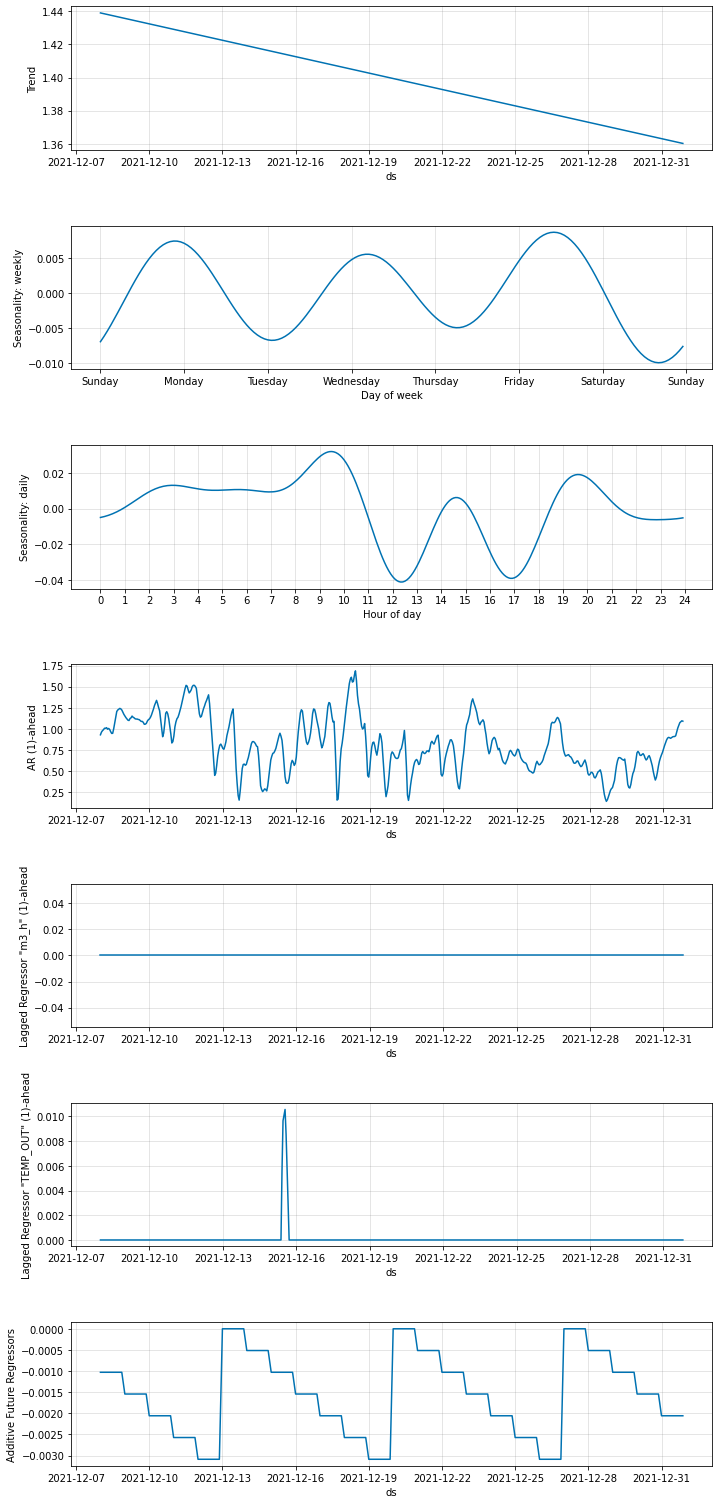

In [ ]:
testNPFig = m2020.plot_components(forecastTestNP)


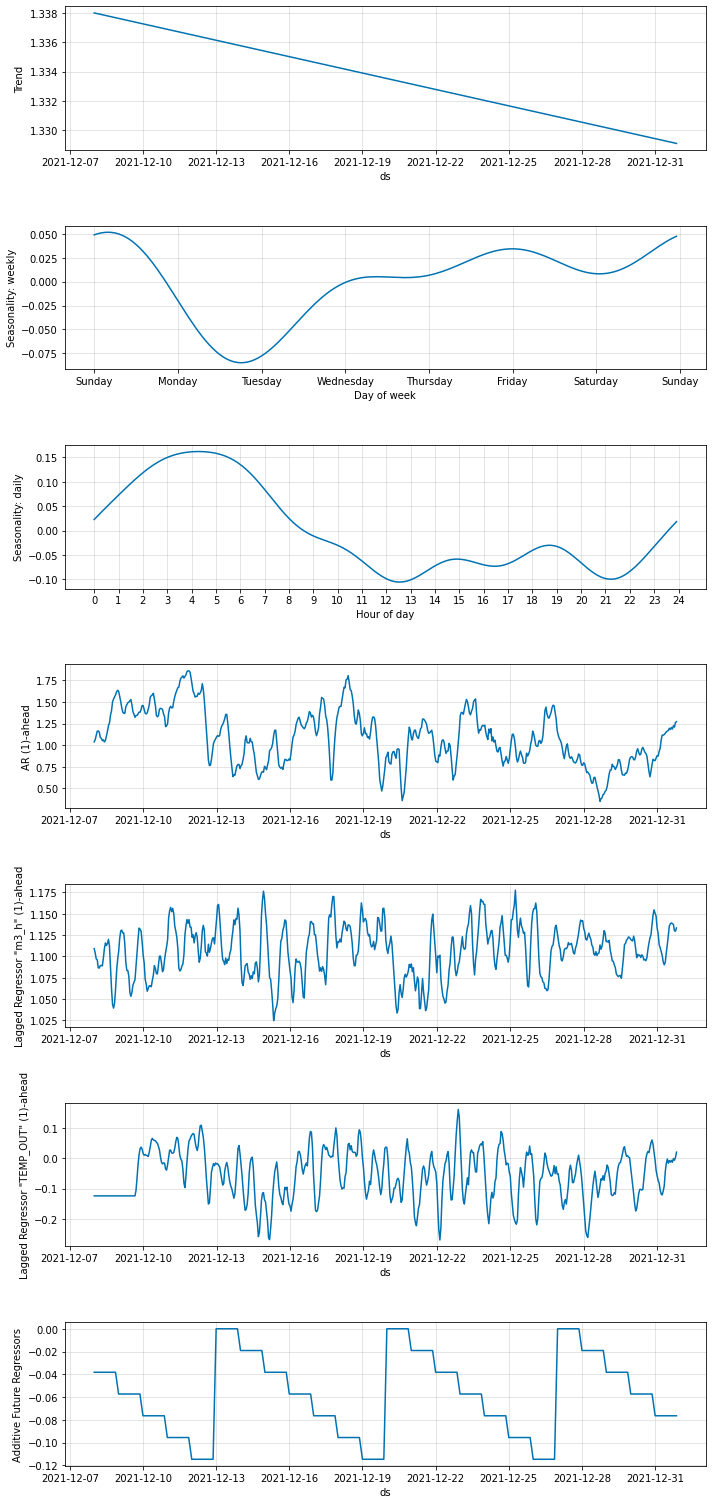

In [ ]:
testNPFig = m2020.plot_components(forecastTestNP)

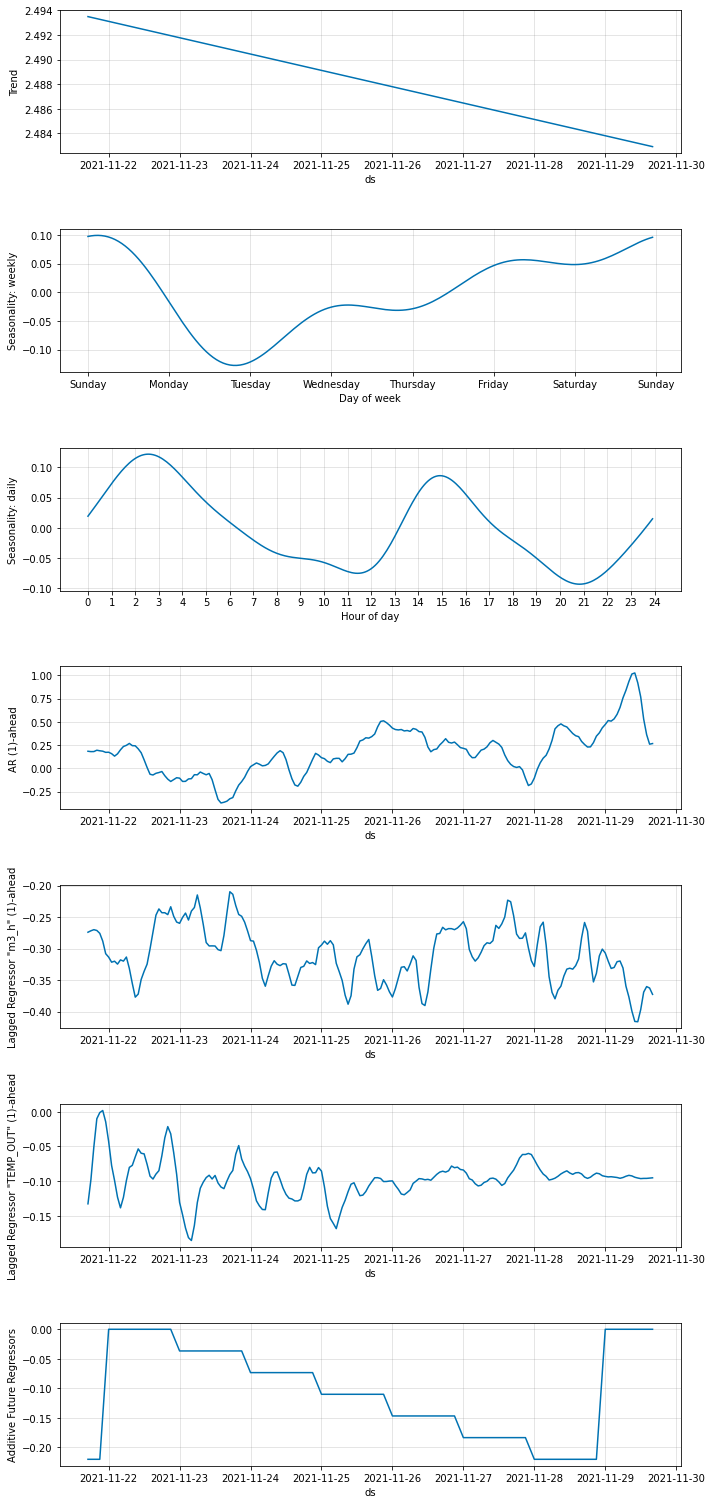

In [ ]:
fullQueryNPFig = m2020.plot_components(fullQueryNP)

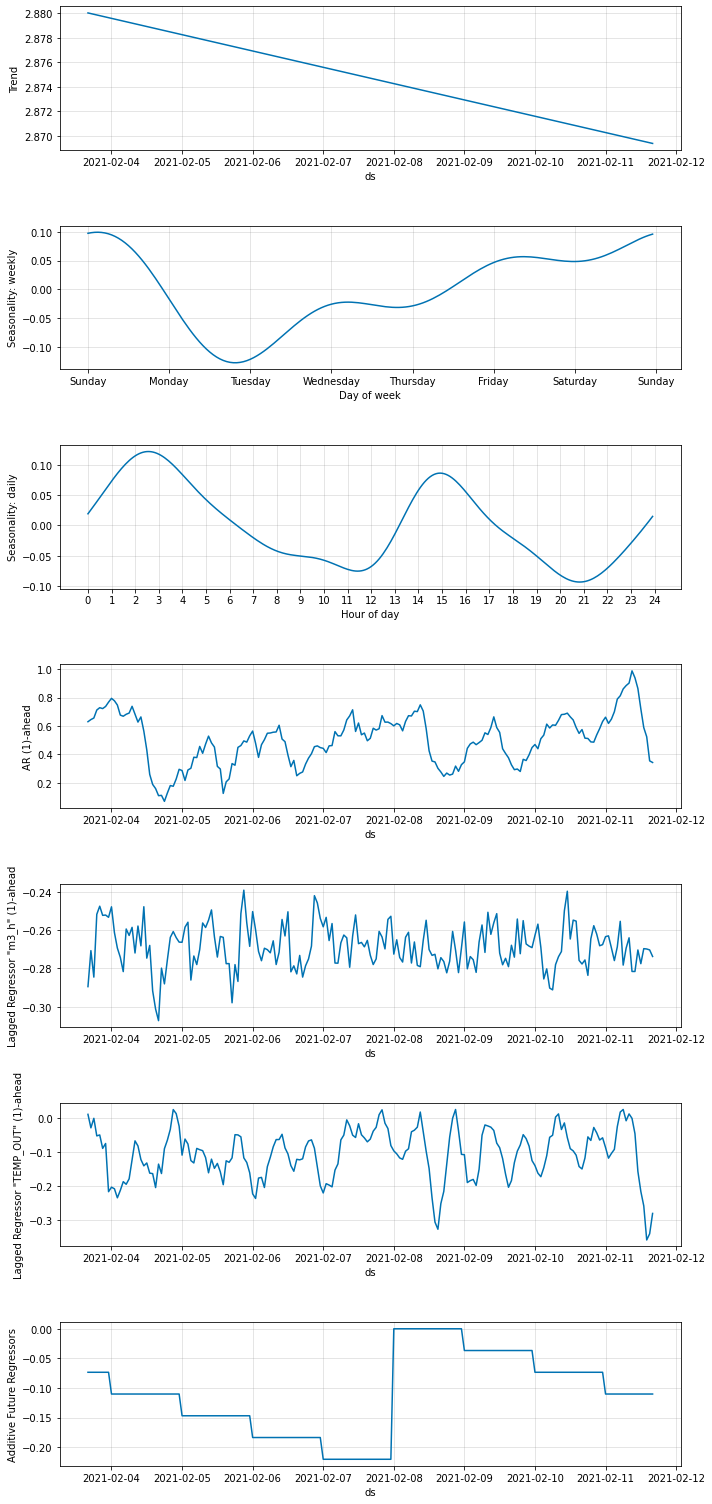

In [ ]:
queryMatchNPFig = m2020.plot_components(queryMatchNP)

In [ ]:
# m.plot(fullQueryNP)

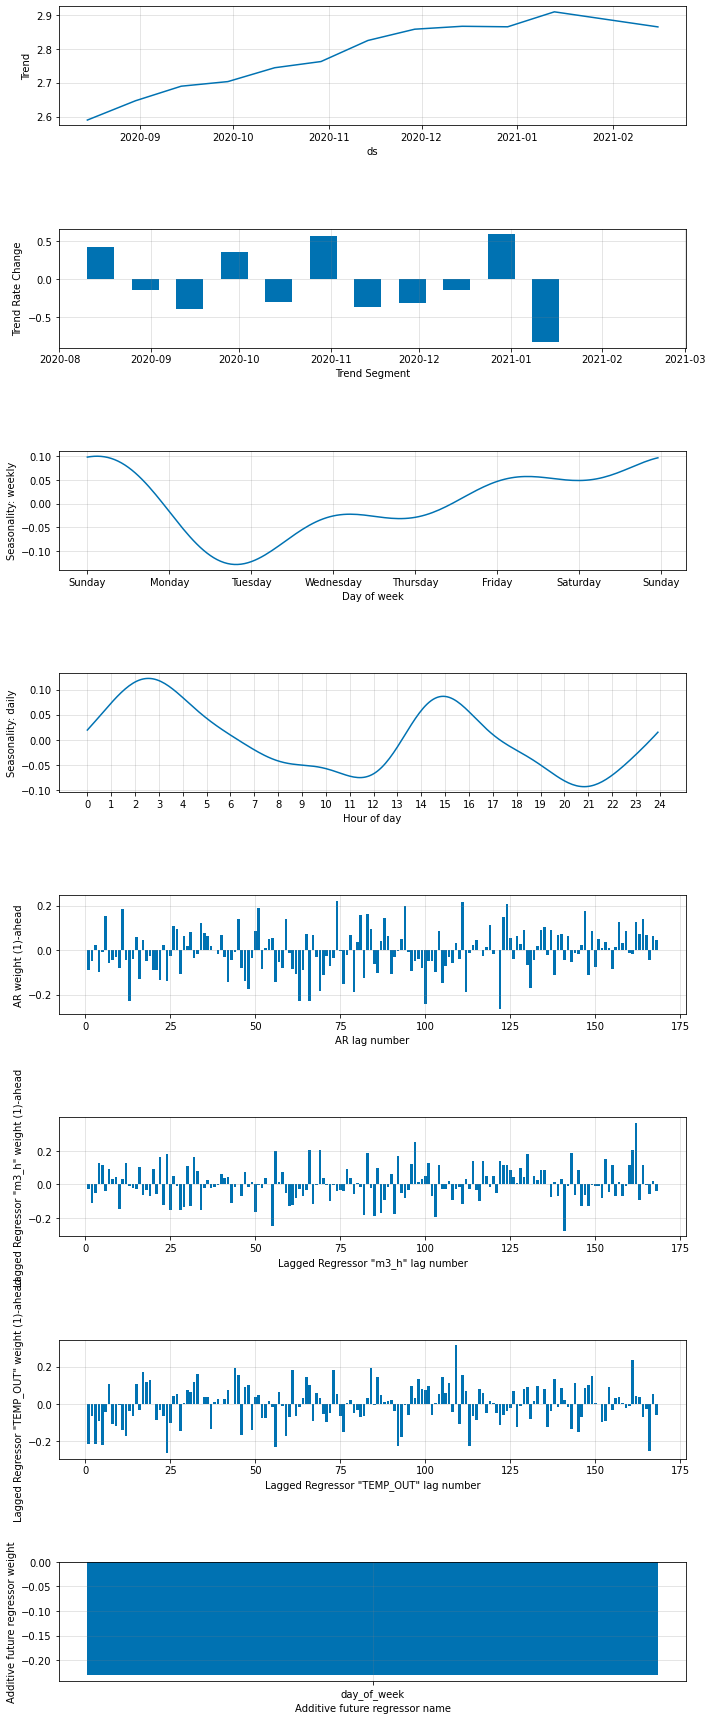

In [ ]:
NPParamsFig = m2020.plot_parameters()

In [ ]:
# RMSE
def rmse(obs, pred):
 return sqrt(mean_squared_error(obs, pred))                                                # algo for RMSE

# MAPE - from 'https://vedexcel.com/how-to-calculate-mape-in-python/'
def mape(obs, pred):
    return np.mean(np.abs((obs - pred) / (obs)))*100                                      # algo for MAPE

#SMAPE - from  'https://vedexcel.com/how-to-calculate-smape-in-python/'
def smape(obs, pred):
    return 100/len(obs) * np.sum(2 * np.abs(pred - obs) / (np.abs(obs) + np.abs(pred)))

In [ ]:
print(rmse(fullQueryGT, fullQuery))
print(rmse(fullQueryGT, fullQueryNP['yhat1'][:-1]))
print(rmse(fullQueryMatchGT, fullQueryMatch))
print(rmse(fullQueryMatchGT, queryMatchNP['yhat1']))

0.14272568340965508
0.45038190806150946
0.08725589819094529
0.07130814991676533


In [ ]:
print(rmse(fullQueryGT, fullQuery))
print(rmse(fullQueryGT, fullQueryNP['yhat1'][:-1]))
print(rmse(fullQueryMatchGT, fullQueryMatch))
print(rmse(fullQueryMatchGT, queryMatchNP['yhat1']))

0.14272568764167498
1.1489149008800752
0.0872558980281841
0.16076203707523049
